<a href="https://colab.research.google.com/github/qader48/weather-forcasting/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
weather_data = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv')
weather_data.head()
weather_data = weather_data[weather_data['time'] <= '2023-12-31']

missing_values = weather_data.isnull().sum()
print(missing_values)

time                             0
temperature                      0
relative_humidity                0
dew_point                        0
precipitation (mm)               0
rain (mm)                        0
snowfall (cm)                    0
pressure_msl (hPa)               0
surface_pressure (hPa)           0
cloud_cover (%)                  0
cloud_cover_low (%)              0
cloud_cover_mid (%)              0
cloud_cover_high (%)             0
vapour_pressure_deficit (kPa)    0
wind_speed_10m (km/h)            0
wind_direction                   0
is_Day                           0
dtype: int64


In [3]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
data = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv')
data

,time,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
0,1980-01-01T00:00,12.7,83,10.0,0.0,0.0,0,1012.8,945.1,1,1,0,0,0.25,7.5,235,0
1,1980-01-01T01:00,12.9,82,9.9,0.0,0.0,0,1012.2,944.5,4,4,0,0,0.26,7.9,231,0
2,1980-01-01T02:00,13.2,82,10.2,0.0,0.0,0,1012.3,944.7,13,14,0,0,0.27,7.5,235,1
3,1980-01-01T03:00,15.9,78,12.0,0.0,0.0,0,1013.5,946.4,23,26,0,0,0.40,6.6,248,1
4,1980-01-01T04:00,19.4,67,13.1,0.0,0.0,0,1014.6,948.2,9,10,0,0,0.75,8.7,265,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389491,2024-06-06T19:00,24.8,90,23.0,0.0,0.0,0,1010.1,945.2,39,2,12,100,0.32,10.6,252,0
389492,2024-06-06T20:00,24.3,92,22.9,0.0,0.0,0,1009.4,944.4,33,3,1,100,0.25,11.9,265,0
389493,2024-06-06T21:00,24.1,91,22.5,0.0,0.0,0,1008.7,943.7,34,4,1,100,0.27,13.1,261,0
389494,2024-06-06T22:00,24.0,89,22.1,0.0,0.0,0,1008.2,943.2,37,8,0,100,0.32,13.7,267,0


In [5]:
# Convert the 'DateTime' column to a datetime object to enable datetime operations
data['time'] = pd.to_datetime(data['time'])

# Extract hour from the DateTime column
data['hour'] = data['time'].dt.hour

# Extract day of the week from the DateTime column (0=Monday, 6=Sunday)
data['day_of_week'] = data['time'].dt.dayofweek

# Extract quarter of the year from the DateTime column (1=Jan-Mar, 4=Oct-Dec)
data['quarter'] = data['time'].dt.quarter

# Extract month from the DateTime column (1=January, 12=December)
data['month'] = data['time'].dt.month

# Extract year from the DateTime column
data['year'] = data['time'].dt.year

# Extract day of the year from the DateTime column (1=January 1st, 365=December 31st)
data['day_of_year'] = data['time'].dt.dayofyear


In [7]:
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']
target_columns = ['temperature', 'relative_humidity', 'dew_point', 'pressure_msl (hPa)']

X = data[features]
y = data[target_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
xgboost_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 1000,  # Increased to allow early stopping
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10
}

models = {}

for target in target_columns:
    model = xgb.XGBRegressor(**xgboost_params)  # Use the provided parameters
    # Assuming 'time' is not a feature, remove it from X_train and X_test
    X_train_selected = X_train[[col for col in X_train.columns if col != 'time']]
    X_test_selected = X_test[[col for col in X_test.columns if col != 'time']]
    model.fit(X_train_selected, y_train[target],
              eval_set=[(X_test_selected, y_test[target])],
              verbose=False)  # Set verbose=False to suppress output
    models[target] = model

In [9]:
predictions = {}
for target in target_columns:
    predictions[target] = models[target].predict(X_test)

In [10]:
for target in target_columns:
    mse = mean_squared_error(y_test[target], predictions[target])
    print(f'Mean Squared Error for {target}: {mse}')

Mean Squared Error for temperature: 1.3246678795031832
Mean Squared Error for relative_humidity: 55.79384457894137
Mean Squared Error for dew_point: 3.498116257022293
Mean Squared Error for pressure_msl (hPa): 1.2989611300208292


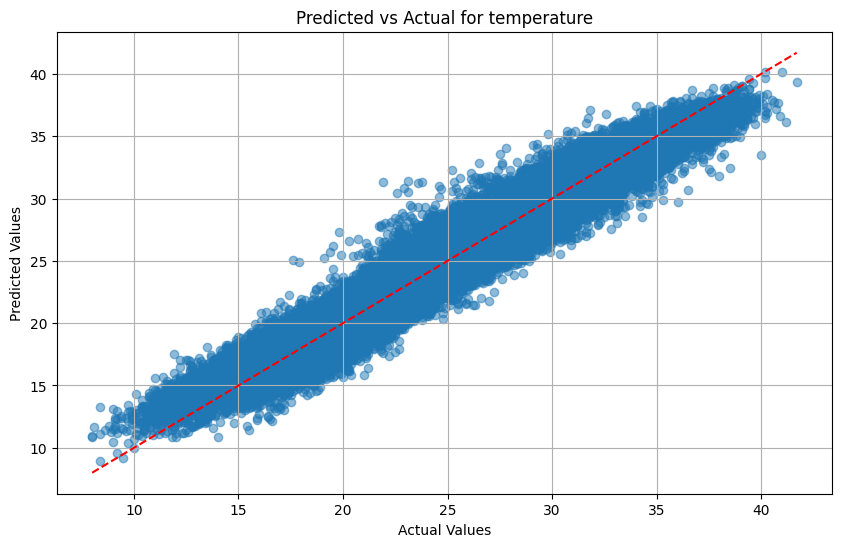

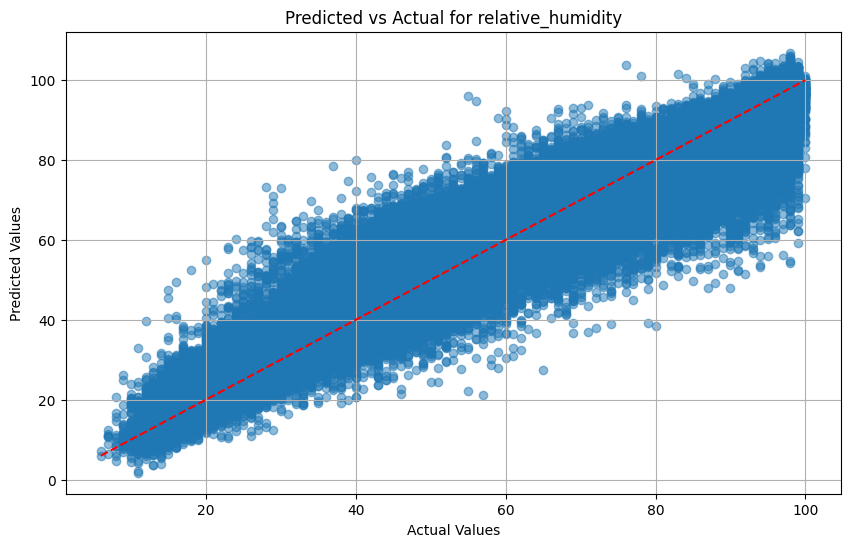

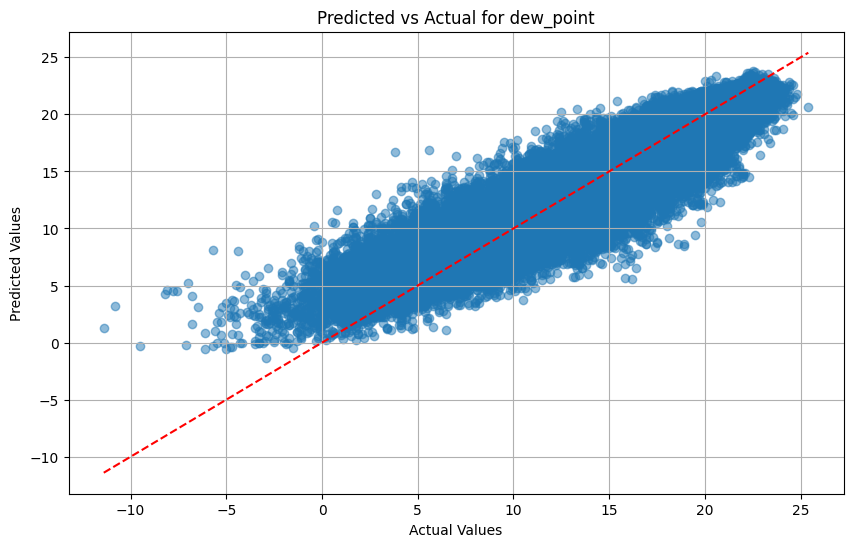

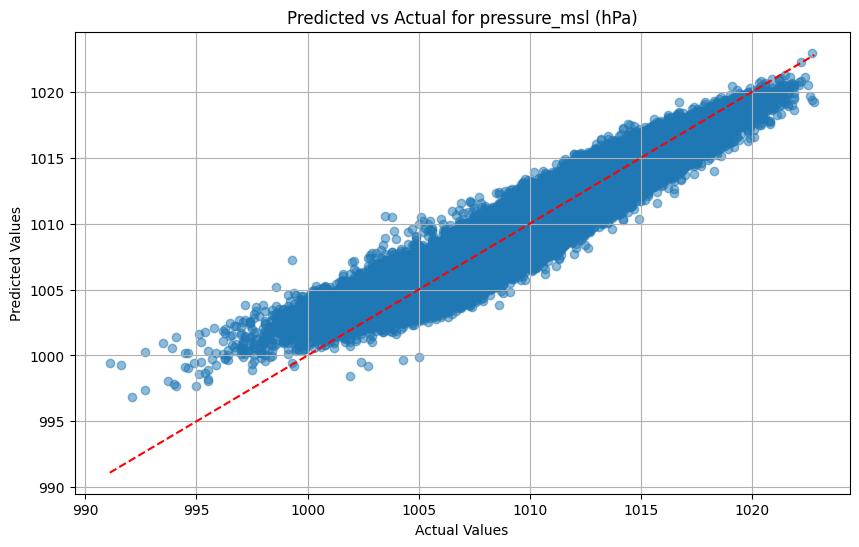

In [14]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values for each target variable
for target in target_columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.scatter(y_test[target], predictions[target], alpha=0.5)  # Scatter plot
    plt.plot([y_test[target].min(), y_test[target].max()], [y_test[target].min(), y_test[target].max()], 'r--')  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual for {target}')
    plt.grid(True)
    plt.show()

In [15]:
# Create a date range for the next year
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='H')

# Create a DataFrame for future data
future_data = pd.DataFrame({'time': future_dates})

# Extract features from future dates
future_data['hour'] = future_data['time'].dt.hour
future_data['day_of_week'] = future_data['time'].dt.dayofweek
future_data['quarter'] = future_data['time'].dt.quarter
future_data['month'] = future_data['time'].dt.month
future_data['year'] = future_data['time'].dt.year
future_data['day_of_year'] = future_data['time'].dt.dayofyear

# Select the features for prediction
X_future = future_data[features]

In [16]:
future_predictions = {}
for target in target_columns:
    future_predictions[target] = models[target].predict(X_future)

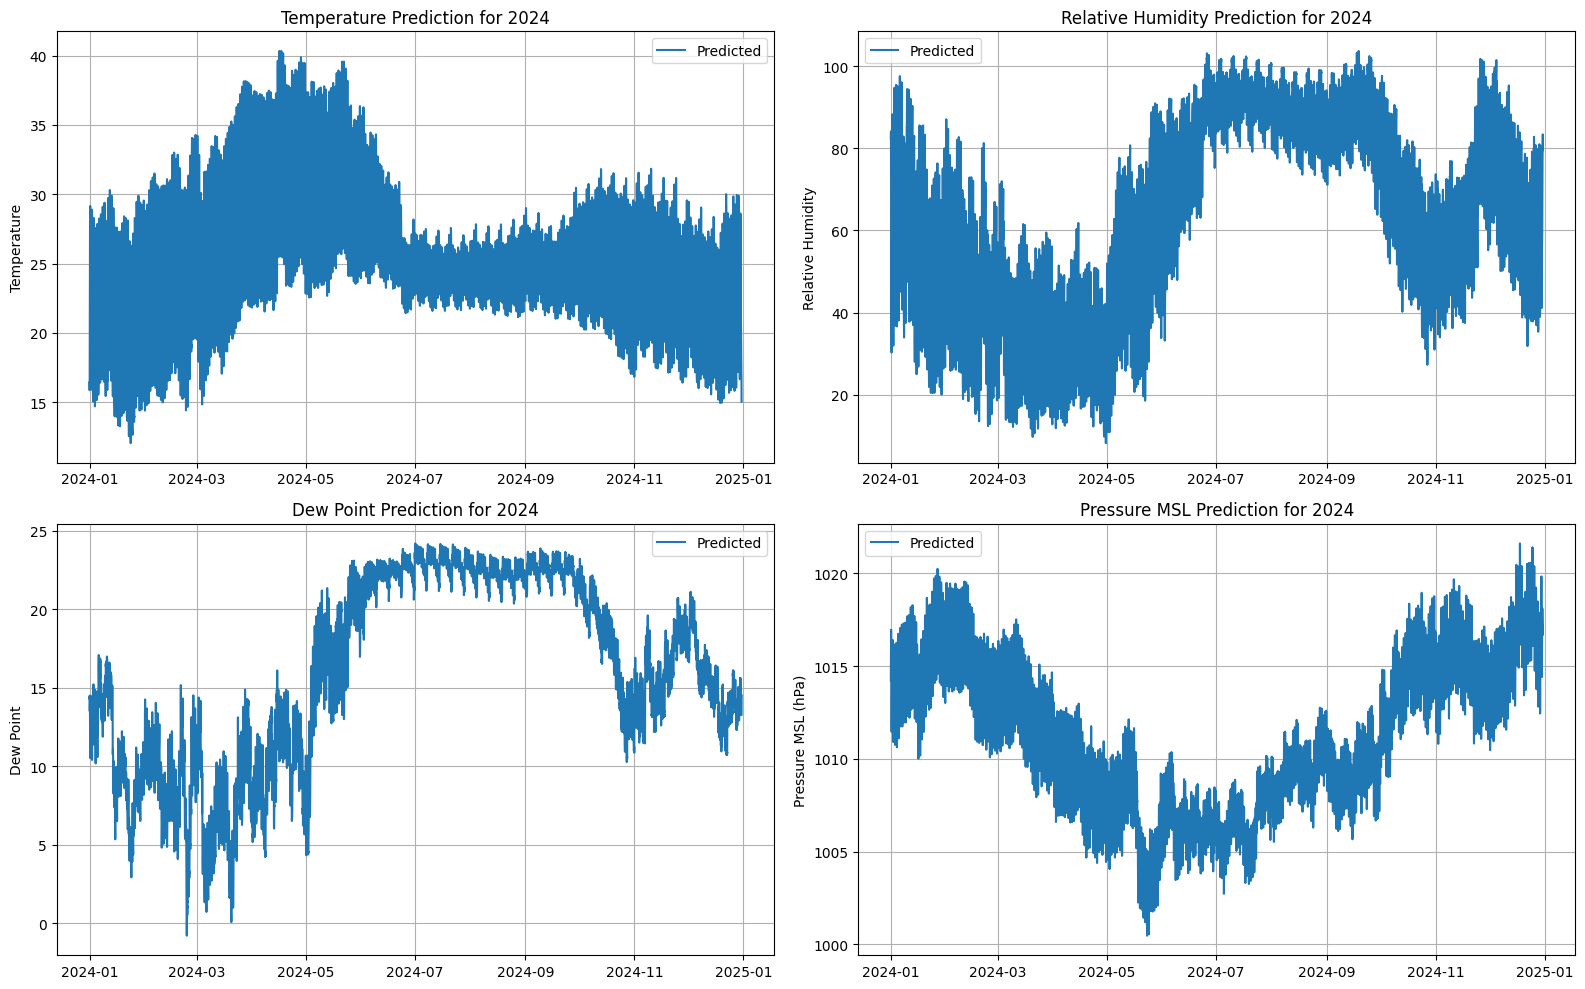

In [19]:
import matplotlib.pyplot as plt

# Visualize the predictions for all four features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # Create a 2x2 grid of subplots

# Plot each feature on a separate subplot
axes[0, 0].plot(future_data['time'], future_data['temperature'], label='Predicted')
axes[0, 0].set_title('Temperature Prediction for 2024')
axes[0, 0].set_ylabel('Temperature')

axes[0, 1].plot(future_data['time'], future_data['relative_humidity'], label='Predicted')
axes[0, 1].set_title('Relative Humidity Prediction for 2024')
axes[0, 1].set_ylabel('Relative Humidity')

axes[1, 0].plot(future_data['time'], future_data['dew_point'], label='Predicted')
axes[1, 0].set_title('Dew Point Prediction for 2024')
axes[1, 0].set_ylabel('Dew Point')

axes[1, 1].plot(future_data['time'], future_data['pressure_msl (hPa)'], label='Predicted')
axes[1, 1].set_title('Pressure MSL Prediction for 2024')
axes[1, 1].set_ylabel('Pressure MSL (hPa)')

# Add legends and grid to all subplots
for ax in axes.flat:
    ax.legend()
    ax.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [20]:
data['time'] = pd.to_datetime(data['time']) # Convert 'time' column to datetime if not already
actual_data_2022_2023 = data[(data['time'].dt.year == 2022) | (data['time'].dt.year == 2023)]

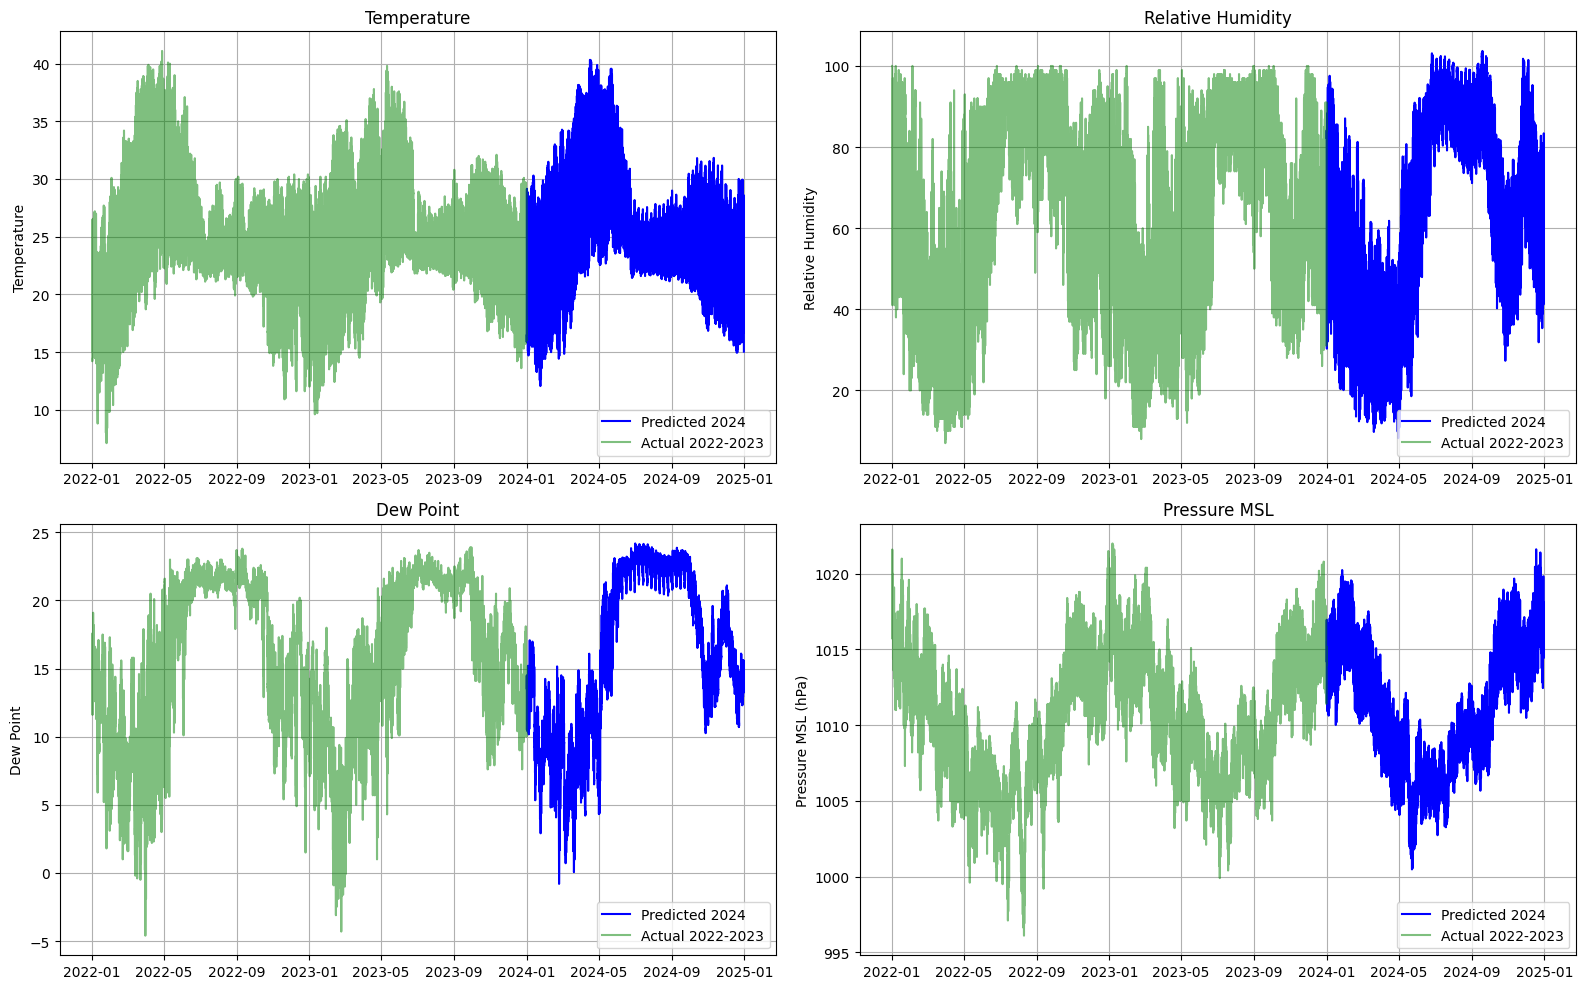

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Temperature
axes[0, 0].plot(future_data['time'], future_data['temperature'], label='Predicted 2024', color='blue')
axes[0, 0].plot(actual_data_2022_2023['time'], actual_data_2022_2023['temperature'], label='Actual 2022-2023', color='green', alpha=0.5)
axes[0, 0].set_title('Temperature')
axes[0, 0].set_ylabel('Temperature')

# Relative Humidity
axes[0, 1].plot(future_data['time'], future_data['relative_humidity'], label='Predicted 2024', color='blue')
axes[0, 1].plot(actual_data_2022_2023['time'], actual_data_2022_2023['relative_humidity'], label='Actual 2022-2023', color='green', alpha=0.5)
axes[0, 1].set_title('Relative Humidity')
axes[0, 1].set_ylabel('Relative Humidity')

# Dew Point
axes[1, 0].plot(future_data['time'], future_data['dew_point'], label='Predicted 2024', color='blue')
axes[1, 0].plot(actual_data_2022_2023['time'], actual_data_2022_2023['dew_point'], label='Actual 2022-2023', color='green', alpha=0.5)
axes[1, 0].set_title('Dew Point')
axes[1, 0].set_ylabel('Dew Point')

# Pressure MSL
axes[1, 1].plot(future_data['time'], future_data['pressure_msl (hPa)'], label='Predicted 2024', color='blue')
axes[1, 1].plot(actual_data_2022_2023['time'], actual_data_2022_2023['pressure_msl (hPa)'], label='Actual 2022-2023', color='green', alpha=0.5)
axes[1, 1].set_title('Pressure MSL')
axes[1, 1].set_ylabel('Pressure MSL (hPa)')

# Add legends and grid to all subplots
for ax in axes.flat:
    ax.legend()
    ax.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()